# CNN

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
    %pip install hurst==0.0.5
    %pip install imbalanced_learn==0.12.3
    %pip install imblearn==0.0
    %pip install protobuf==5.27.0
    %pip install pykalman==0.9.7
    %pip install tqdm==4.66.4
    %pip install shap==0.45.1
    %pip install tensorflow==2.15.1
!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/intra-day-agriculture-futures-trades-2023-2024"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


In [3]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(f'Tensorflow version: [{tf.__version__}]')

tf.get_logger().setLevel('INFO')

#tf.config.set_soft_device_placement(True)
#tf.config.experimental.enable_op_determinism()
#tf.random.set_seed(1)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
  gpus = tf.config.experimental.list_physical_devices('GPU')
  if len(gpus) > 0:
    try:
        strategy = tf.distribute.MirroredStrategy()
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
  else:
    # CPU is final fallback
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

def is_tpu_strategy(strategy):
    return isinstance(strategy, tf.distribute.TPUStrategy)

print("Number of accelerators:", strategy.num_replicas_in_sync)
os.getcwd()

2024-06-01 22:29:28.777505: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 22:29:28.807917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 22:29:28.807946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 22:29:28.809267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 22:29:28.815533: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version: [2.15.1]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
1 Physical GPUs, 1 Logical GPUs
Physical devices cannot be modified after being initialized
Running on 1 GPU(s)
Number of accelerators: 1


2024-06-01 22:29:30.485726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 22:29:30.513386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 22:29:30.513430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 22:29:30.518665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 22:29:30.518715: I external/local_xla/xla/stream_executor

'/mnt/c/Users/adamd/workspace/intra_day_futures_arb'

# Instruments

## Data Load

In [4]:
import pandas as pd
import numpy as np
from algo_trading_utility_script import *

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)

HALF_LIFE, HURST = get_ou(futs_df, f'{TARGET_FUT}_Close')

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

futs_df.head(2)

./data//futures_15m.csv
(4688, 128)
Half-Life: 402
Hurst: 0.4924908823368793


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2YY_Open,2YY_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 15:30:00+00:00,3.587,3.587,3.574,3.580,191.0,55.0,3.579749,0.013,4.167,4.179,...,1188.444270,9.25,600.5,605.0,600.00,604.5,7203.0,2296.0,602.673732,5.00
2023-06-01 15:45:00+00:00,3.583,3.588,3.581,3.583,42.0,22.0,3.584048,0.007,4.173,4.173,...,1191.678377,3.00,604.5,607.5,602.75,605.0,4481.0,1411.0,605.502724,4.75


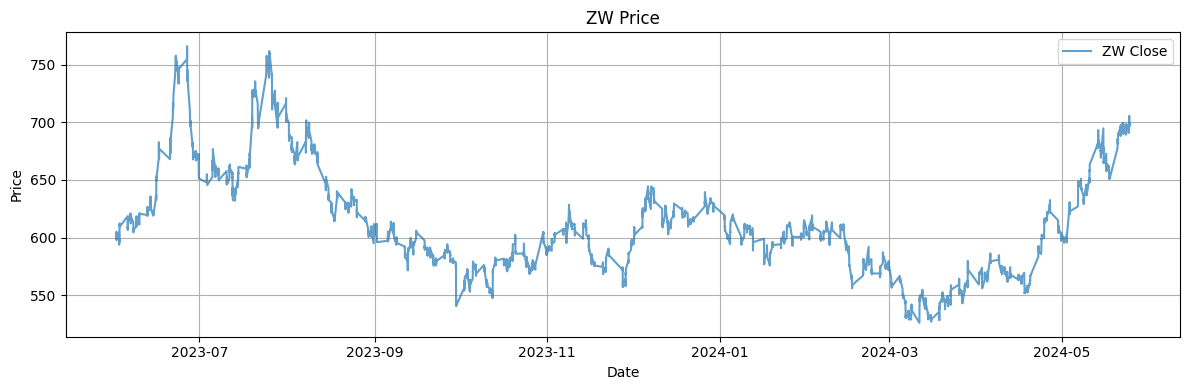

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare the Data

In [6]:
import pickle
from sklearn.preprocessing import StandardScaler, normalize, FunctionTransformer
from tqdm import tqdm

BIAS = 0.
CLASS_WEIGHTS = {0: 1., 1: 1.}
SCALERS = None
TEST_SPLIT = 0.8
TRAIN_SIZE = int(len(futs_df) * TEST_SPLIT)
CACHE = True
FUTURES_TMP_FILE = "./tmp/futures.pkl"
os.makedirs("./tmp/", exist_ok=True)

# FEATURES_SELECTED from feature selection GBC notebook.
COLS_TO_SCALE = ['10Y_Barcount', '10Y_Spread', '10Y_Volume', '2YY_Spread', '2YY_Volume',
                'Filtered_X', 'KG_X', 'KG_Z1', 'RTY_Spread', 'SD', 'Spread',
                'VXM_Open', 'VXM_Spread', 'Volume'] # StockFeat.list + MARKET_COLS + BB_COLS + SR_COLS + KF_COLS # FEATURES_SELECTED
FEATURES = FEATURES_SELECTED # StockFeat.list + MARKET_COLS + KF_COLS + BB_COLS + MOM_COLS + SR_COLS # FEATURES_SELECTED

print(f"Scaling these features: {COLS_TO_SCALE}")
print(f"Training on these features: {FEATURES}")

def oversample_mean_reversions(train_agri_ts, window, period=INTERVAL, hurst=HURST):
    samples = []
    for df in tqdm(train_agri_ts, desc="oversample_mean_reversions"):
        bb_df = df.copy()
        results_df = param_search_bbs(bb_df, StockFeatExt.CLOSE, period, initial_window=window * 2, window_min=window // 2, hurst=hurst)
        results_df = results_df[results_df["Metric"] == "Sharpe"]
        bb_df, _ = bollinger_band_backtest(bb_df, StockFeatExt.CLOSE, results_df["Window"].iloc[0], period, std_factor=results_df["Standard_Factor"].iloc[0])

        samples.append(bb_df[train_agri_ts[0].columns].reset_index(drop=True))
    return train_agri_ts + samples

def normalize_and_label_data(ts, meta_label=META_LABEL, cols_to_scale=COLS_TO_SCALE, scalers=None):
    def _get_first_difference(data_df):
        return data_df.diff(1).fillna(0)

    def _get_log_returns(data_df):
        return np.log(data_df / data_df.shift(1)).fillna(0)

    y0 = 0
    y1 = 0
    dfs = []
    new_scalers = []
    for df, scaler in tqdm(zip(ts, scalers or [None] * len(ts)), desc="label_data"):
        df = aug_metalabel_mr(df)
        if (df[meta_label] > 0).sum() == 0:
            print("A DS with no Positive Label was found!")
            continue
        y0 += (df[meta_label] == 0).sum()
        y1 += (df[meta_label] > 0).sum()
        if cols_to_scale is not None:
            if scaler is None:
                scaler= StandardScaler() # FunctionTransformer(_get_first_difference) #
                scaler.fit(df[cols_to_scale])
                new_scalers.append(scaler)
            df[cols_to_scale] = scaler.transform(df[cols_to_scale])
            df = df.iloc[1:] # First data is always nan after a transform
        df = df.loc[:, ~df.columns.duplicated(keep="first")]
        dfs.append(df.dropna())

    # Unless we SMOTE, this dataset is imbalanced.
    total = y0 + y1
    class_weight_0 = total / y0 if y0 != 0 else 0
    class_weight_1 = total / y1 if y1 != 0 else 0
    class_weights = {0: class_weight_0, 1: class_weight_1}

    # the bias will shift activation to be more sensible to the imbalance.
    bias = np.log(y1 / y0)

    return dfs, class_weights, bias, new_scalers if len(new_scalers)> 0 else scalers

with strategy.scope():
    if not os.path.exists(FUTURES_TMP_FILE):
        futs_exog_df = process_exog(MARKET_FUTS, futs_df)
        train_agri_ts, val_agri_ts = process_futures(FUTS, futs_df, futs_exog_df, TRAIN_SIZE, INTERVAL)
        # Same as SMOTE, but reusing the same TS with different MR algos.
        train_agri_ts = oversample_mean_reversions(train_agri_ts, HALF_LIFE)
        val_agri_ts = oversample_mean_reversions(val_agri_ts, HALF_LIFE)
        if CACHE:
            with open(FUTURES_TMP_FILE, 'wb') as f:
                pickle.dump((train_agri_ts, val_agri_ts), f)
    else:
        with open(FUTURES_TMP_FILE, 'rb') as f:
            train_agri_ts, val_agri_ts = pickle.load(f)
    train_agri_ts, CLASS_WEIGHTS, BIAS, SCALERS = normalize_and_label_data(train_agri_ts, cols_to_scale=COLS_TO_SCALE)
    val_agri_ts, val_weights, _, _ = normalize_and_label_data(val_agri_ts, cols_to_scale=COLS_TO_SCALE, scalers=SCALERS)

print(f"train weights: {CLASS_WEIGHTS}")
print(f"test weights: {val_weights}")
np.shape(train_agri_ts)

Scaling these features: ['10Y_Barcount', '10Y_Spread', '10Y_Volume', '2YY_Spread', '2YY_Volume', 'Filtered_X', 'KG_X', 'KG_Z1', 'RTY_Spread', 'SD', 'Spread', 'VXM_Open', 'VXM_Spread', 'Volume']
Training on these features: ['10Y_Barcount', '10Y_Spread', '10Y_Volume', '2YY_Spread', '2YY_Volume', 'CONTRA', 'Filtered_X', 'KG_X', 'KG_Z1', 'RTY_Spread', 'SD', 'Spread', 'TSMOM', 'VXM_Open', 'VXM_Spread', 'Volume']


label_data: 12it [00:00, 16.82it/s]

A DS with no Positive Label was found!
A DS with no Positive Label was found!


label_data: 17it [00:01, 16.26it/s]

A DS with no Positive Label was found!
A DS with no Positive Label was found!


label_data: 32it [00:02, 13.70it/s]
label_data: 18it [00:00, 56.53it/s]

A DS with no Positive Label was found!
A DS with no Positive Label was found!
A DS with no Positive Label was found!
A DS with no Positive Label was found!
A DS with no Positive Label was found!


label_data: 28it [00:00, 51.59it/s]


A DS with no Positive Label was found!
A DS with no Positive Label was found!
A DS with no Positive Label was found!
train weights: {0: 1.1695385335100636, 1: 6.898364102227186}
test weights: {0: 1.1360058132493642, 1: 8.352626892252895}


(28, 3749, 92)

In [7]:
sample = val_agri_ts[0]
print(sample[META_LABEL].value_counts())

sampled_pattenrs = sample[sample[META_LABEL] > 0]
sampled_pattenrs[FEATURES + [META_LABEL, "Ret"]].tail(10)

mr_label
0    869
1     68
Name: count, dtype: int64


,10Y_Barcount,10Y_Spread,10Y_Volume,2YY_Spread,2YY_Volume,CONTRA,Filtered_X,KG_X,KG_Z1,RTY_Spread,SD,Spread,TSMOM,VXM_Open,VXM_Spread,Volume,mr_label,Ret
889,-0.080947,-0.254530,-0.464782,0.647696,-0.158283,0,0.437118,0.486992,0.057696,-0.843745,-1.657530,-0.300210,1,-1.838648,-1.034242,-0.213835,1,0.000000
890,0.447427,-0.528218,-0.082681,-0.443716,-0.260445,0,-0.495150,0.554825,0.207430,-0.485751,-1.537164,-0.123227,1,-1.832532,0.665674,0.137102,1,0.003256
900,0.070017,-0.254530,0.614805,-0.287800,0.250365,0,2.587925,0.749662,0.453875,2.706367,-0.936518,0.938668,1,-1.875345,-0.334277,3.436348,1,0.000000
901,7.731432,4.671852,8.899728,3.921930,4.745491,1,2.440144,-0.703702,0.239236,2.557203,-0.813073,-0.477192,-1,-1.826416,0.665674,0.977290,1,0.000000
902,2.296734,1.113910,1.936996,2.050939,0.659013,1,2.277819,0.598209,0.165394,0.588233,-0.708098,-0.123227,-1,-1.728558,0.965659,1.047540,1,0.000000
903,3.240258,1.250754,2.507116,0.803612,1.374146,1,1.293317,0.639689,0.307975,1.095392,-0.599960,0.230738,-1,-1.838648,-0.334277,1.215203,1,0.000000
904,1.768360,0.429690,2.343358,0.179948,1.374146,1,1.393706,0.449799,0.442379,-0.396252,-0.636827,0.938668,-1,-1.844764,-0.334277,0.774971,1,0.000000
905,-0.005465,-0.665062,-0.040225,-0.443716,-0.362607,1,0.844519,0.395538,0.405280,0.379403,-0.806317,0.053755,-1,-1.832532,1.265644,0.354408,1,0.000000
906,0.636131,0.156002,0.396462,0.803612,-0.056121,1,0.287028,-0.131515,0.229083,1.244556,-1.240336,-0.654175,-1,-1.697978,0.865664,-0.235691,1,0.000000
907,-0.118688,-0.254530,0.093207,-0.287800,0.761175,1,-0.272102,0.620663,0.230367,-0.247088,-1.199656,-0.477192,-1,-1.820300,-0.434272,0.250751,1,0.004287


In [8]:
WINDOW = 511  # window is the k+k-1xd-1 or the sum i=0..n of 1+sum(receptive feild)x2^i
WINDOW_TMP_PATH = "./tmp/"
# TPU see: https://github.com/tensorflow/tensorflow/issues/41635
BATCH_SIZE = 8  * strategy.num_replicas_in_sync # Default 8
print(f"BATCH_SIZE: {BATCH_SIZE}")

def prepare_windows(data_df, label_df, window_size=WINDOW):
    """
    Prepare windows of features and corresponding labels for classification.
    IMPORTANT: There is no padding, incomplete timewindows are discarded!

    Parameters:
    - data_df: DataFrame containing the features.
    - label_df: DataFrame containing the labels.
    - window_size: The size of the input window.

    Returns:
    - X: Array of input windows.
    - y: Array of corresponding labels.
    """
    X, y = [], []
    for i in range(len(data_df) - window_size):
        input_window = data_df.iloc[i : i + window_size].values
        assert not np.isnan(input_window).any(), "NaN values found in input window"
        X.append(input_window)
        if label_df is not None:
            target_label = label_df.iloc[i + window_size]
            y.append([target_label])
            assert not np.isnan(target_label).any(), "NaN values found in target label"
    return np.array(X), np.array(y)

def prepare_windows_with_disjoint_ts(ts_list, window_size=WINDOW):
    """
    Generator function to yield windows of features and corresponding labels from multiple time series.

    Parameters:
    - ts_list: List of DataFrames, each containing a time series.
    - window_size: The size of the input window.

    Yields:
    - features: The input window of features.
    - labels: The corresponding label.
    """
    for data_df in ts_list:
        X, y = prepare_windows(data_df[FEATURES], data_df[META_LABEL], window_size=window_size)
        for features, labels in zip(X, y):
            yield features, labels

def create_windowed_dataset_from_generator(ts_list, window_size=WINDOW, batch_size=BATCH_SIZE):
    """
    Create a TensorFlow dataset from a generator.

    Parameters:
    - ts_list: List of DataFrames, each containing a time series.
    - window_size: The size of the input window.
    - batch_size: The batch size for the dataset.

    Returns:
    - dataset: A TensorFlow dataset.
    """
    dataset = tf.data.Dataset.from_generator(
        lambda: prepare_windows_with_disjoint_ts(ts_list, window_size=window_size),
        output_signature=(
            tf.TensorSpec(shape=(window_size, len(FEATURES)), dtype=tf.float32),
            tf.TensorSpec(shape=(1,), dtype=tf.float32)  # Assuming labels are floats for binary classification
        )
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def create_dataset_from_generator(ts_list, batch_size):
    def generator(ts_list):
        full_df = pd.concat(ts_list)
        for i, row in full_df.iterrows():
            yield row[FEATURES].values, row[META_LABEL]  # Reshape to match (1,)

    output_signature = (
        tf.TensorSpec(shape=(len(FEATURES),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: generator(ts_list),
        output_signature=output_signature
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

with strategy.scope():
    train_dataset = create_windowed_dataset_from_generator(train_agri_ts, batch_size=BATCH_SIZE)
    val_dataset = create_windowed_dataset_from_generator(val_agri_ts, batch_size=BATCH_SIZE)

BATCH_SIZE: 8


In [9]:
# INPUT_SHAPE = (len(FEATURES), ) # The expected shape, where the None shape is BATCH_SIZE

sampled_dataset = val_dataset.shuffle(buffer_size=250).take(1)
for features, labels in train_dataset.take(1):
    INPUT_SHAPE = features.numpy().shape[1:]  # Assuming the shape is (batch_size, len(FEATURES))
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

print("INPUT_SHAPE:", INPUT_SHAPE)

Features: [[[-0.19416969 -0.39137366 -0.47691235 ...  2.9686022   0.1656985
    0.38687924]
  [ 1.013541    4.8086963   0.37826636 ...  2.9196734   1.5656295
    0.16207966]
  [-0.798025   -0.39137366 -0.6649304  ...  2.766771    1.1656492
    0.8692616 ]
  ...
  [ 0.78709525  1.9349734   0.46924284 ...  0.19189532  0.7656689
   -0.05803659]
  [ 0.71161336  1.9349734   1.6822623  ...  0.19801141 -0.03429164
   -0.62627995]
  [ 1.013541    1.5244415   0.27515972 ...  0.2163597   0.7656689
   -0.3409094 ]]

 [[ 1.013541    4.8086963   0.37826636 ...  2.9196734   1.5656295
    0.16207966]
  [-0.798025   -0.39137366 -0.6649304  ...  2.766771    1.1656492
    0.8692616 ]
  [-0.3451335   0.5665339  -0.34348023 ...  2.8156998   0.7656689
   -0.21914294]
  ...
  [ 0.71161336  1.9349734   1.6822623  ...  0.19801141 -0.03429164
   -0.62627995]
  [ 1.013541    1.5244415   0.27515972 ...  0.2163597   0.7656689
   -0.3409094 ]
  [ 0.5606495   0.5665339   0.16598797 ...  0.13685048  0.5656788
   -0.

# CNN 

## Architecture

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Add, Multiply, Input, Flatten, Dense, GlobalAveragePooling1D, MaxPooling1D, SpatialDropout1D, Activation, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import Constant, HeNormal

MODEL_NAME = "WAVENET" # BASE, RESNET, WAVENET
MAX_DILATION = 8
FILTERS = 32
DROPRATE = 0.4
KERNEL_SIZE = 3
REG_WEIGHTS = 1e-5
CONVOLUTIONS = 12
DENSE_SIZE = 128
DENSE_DEPTH = 8

def wavenet_block(inputs, layer_id, filters, kernel_size, dilation_rate, reg_param, dropout_rate):
    conv_f = Conv1D(filters, kernel_size,
                    dilation_rate=dilation_rate,
                    padding='causal',
                    kernel_regularizer=l2(reg_param),
                    name=f'conv_f_{layer_id}')(inputs)
    conv_f = BatchNormalization()(conv_f)
    conv_g = Conv1D(filters, kernel_size,
                    dilation_rate=dilation_rate,
                    padding='causal',
                    kernel_regularizer=l2(reg_param),
                    name=f'conv_g_{layer_id}')(inputs)
    conv_g = BatchNormalization()(conv_g)

    # Gate
    tanh_out = Activation('tanh')(conv_f)
    sigmoid_out = Activation('sigmoid')(conv_g)
    merged = Multiply()([tanh_out, sigmoid_out])
    merged = SpatialDropout1D(dropout_rate)(merged)

    # Residuals
    skip_out = Conv1D(filters, 1, padding='same',
                      kernel_regularizer=l2(reg_param),
                      name=f'skip_{layer_id}')(merged)
    skip_out = BatchNormalization()(skip_out)
    residual_out = Conv1D(filters, 1, padding='same',
                          kernel_regularizer=l2(reg_param),
                          name=f'residual_{layer_id}')(inputs)
    residual_out = BatchNormalization()(residual_out)
    residual_out = Add()([residual_out, skip_out])

    return residual_out, skip_out

def dense_residual_block(in_x, units, reg_param, dropout_rate, layer_id):
    x = Dense(units, kernel_regularizer=l2(reg_param), name=f'dense_{layer_id}_1')(in_x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, kernel_regularizer=l2(reg_param), name=f'dense_{layer_id}_2')(x)
    x = BatchNormalization()(x)
    if in_x.shape[-1] != units:
        # Original RESNet had a Conv1D
        in_x = Dense(units, kernel_initializer=HeNormal(), kernel_regularizer=l1_l2(reg_param))(in_x)
    x = Add()([in_x, x])
    x = LeakyReLU()(x)
    return x

def build_wavenet_model(input_shape,
                        conv_layers = CONVOLUTIONS,
                        max_dilation = MAX_DILATION,
                        filters = FILTERS,
                        kernel_size = KERNEL_SIZE,
                        reg_param = REG_WEIGHTS,
                        dropout_rate = DROPRATE,
                        dense_units = DENSE_SIZE,
                        dense_layers = DENSE_DEPTH // 4,
                        output_bias=None):
    inputs = Input(shape=input_shape)
    x = inputs
    skip_connections = []

    for block_id in range(conv_layers):
        dilation_rate = min(2 ** block_id, max_dilation)
        x, skip = wavenet_block(x, f'block{block_id}', filters, kernel_size, dilation_rate, reg_param, dropout_rate)
        skip_connections.append(skip)

    # Aggregate skip connections
    x = Add()(skip_connections)
    x = Activation('relu')(x)
    x = GlobalAveragePooling1D()(x)

    # Dense layers
    for layer_id in range(dense_layers):
        x = dense_residual_block(x, dense_units, reg_param, dropout_rate, layer_id)

    outputs = Dense(1, activation='sigmoid', name='output_dense', bias_initializer=Constant(output_bias))(x)
    model = Model(inputs, outputs, name=MODEL_NAME)
    return model

def build_deep_resnet_model(input_shape,
                            reg_param=REG_WEIGHTS,
                            dropout_rate=DROPRATE,
                            output_bias=BIAS,
                            dense_units = DENSE_SIZE,
                            dense_layers = DENSE_DEPTH):
    inputs = Input(shape=input_shape)
    x = inputs
    for layer_id in range(dense_layers):
        x = dense_residual_block(x, dense_units, reg_param, dropout_rate, layer_id)

    outputs = Dense(1, activation='sigmoid', name='output_dense', bias_initializer=Constant(output_bias))(x)
    model = Model(inputs, outputs, name=MODEL_NAME)
    return model

def build_baseline_model(input_shape,
                        reg_param=REG_WEIGHTS,
                        dropout_rate=DROPRATE,
                        output_bias=BIAS,
                        dense_size = DENSE_SIZE):
    inputs = Input(shape=input_shape)

    x = Dense(dense_size, kernel_regularizer=l1_l2(reg_param), kernel_initializer=HeNormal())(inputs)
    x = LeakyReLU()(x)
    x = Dense(dense_size, kernel_regularizer=l1_l2(reg_param), kernel_initializer=HeNormal())(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid', name='output_dense', bias_initializer=Constant(output_bias))(x)

    return Model(inputs, outputs, name=MODEL_NAME)

## Training

In [11]:
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.metrics import  AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import shutil
import json

MODEL_DIR = f"models/{MODEL_NAME}.keras"
MODEL_HISTORY = f"{MODEL_PATH}/history.json"
IMAGES_DIR = f"images/{MODEL_NAME}/images"
LOG_BASEPATH = f"logs/{MODEL_NAME}/tb"
TARGET_METRIC = "tp"

EPOCHS = 30
PATIENCE_EPOCHS = 5
LEARN_RATE =1e-3
LEARN_RATE_MIN = 1e-5
ALPHA = CLASS_WEIGHTS[1] / (CLASS_WEIGHTS[0] + CLASS_WEIGHTS[1])
GAMMA = 2.

PURGE = False
if PURGE:
    # Remove tensorboard logs and other training artefacts for a fresh loop.
    shutil.rmtree(LOG_BASEPATH, ignore_errors=True)
    shutil.rmtree(MODEL_DIR, ignore_errors=True)
    shutil.rmtree(IMAGES_DIR, ignore_errors=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(LOG_BASEPATH, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"alpha: {ALPHA}, gamma {GAMMA}, bias: {BIAS}")

def build_cnn(input_shape, train_dataset, test_dataset=None,
              lr=LEARN_RATE,
              lr_min=LEARN_RATE_MIN,
              target_metric=TARGET_METRIC,
              patience=PATIENCE_EPOCHS,
              epochs=EPOCHS,
              class_weight=CLASS_WEIGHTS,
              initial_bias = BIAS):
    model = build_wavenet_model(
        input_shape=input_shape,
        reg_param=REG_WEIGHTS,
        dropout_rate=DROPRATE,
        output_bias=initial_bias,
    )
    optimizer = Adam(learning_rate=lr, clipnorm=1.)
    loss = BinaryFocalCrossentropy (from_logits=False,
                                    alpha=ALPHA,
                                    gamma=GAMMA,
                                    reduction='sum_over_batch_size',
                                    name='bfce')
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[
            TruePositives(name=TARGET_METRIC), # Max TP
            TrueNegatives(name='tn'),
            FalsePositives(name='fp'),
            FalseNegatives(name='fn'),
            Precision(name='p'),
            Recall(name='r'),
            AUC(name='auc'),
            AUC(name='prc', curve='PR')
        ],
    )
    callbacks = [
        EarlyStopping(
            patience=patience,
            monitor=f"val_{target_metric}",
            restore_best_weights=True,
            mode="max" # TARGET_METRIC max or min
        ),
        ReduceLROnPlateau(
            monitor=f"val_{target_metric}",
            factor=0.5,
            patience=1,
            verbose=1,
            min_lr=lr_min,
            mode="max" # TARGET_METRIC max or min
        ),
        TensorBoard(
            log_dir=LOG_BASEPATH,
            histogram_freq=1,
            write_images=True
        )
    ]
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1,
        class_weight=class_weight
    )
    return model, history

history_dict = None
with strategy.scope():
    if not PURGE and os.path.exists(MODEL_PATH):
        print(f"Loading model from: {MODEL_PATH}")
        model = tf.keras.models.load_model(MODEL_PATH)
        if os.path.exists(MODEL_HISTORY):
            with open(MODEL_HISTORY, 'r') as f:
                history_dict = json.load(f)
    else:
        print(f"input_shape: {INPUT_SHAPE}")
        model, history = build_cnn(INPUT_SHAPE, train_dataset=train_dataset, test_dataset=val_dataset)
        history_dict = history.history
        model.save(MODEL_PATH)
        # float32 is not directly serializable to JSON
        history_dict = {k: [float(i) for i in v] for k, v in history_dict.items()}
        with open(MODEL_HISTORY, 'w') as f:
            json.dump(history_dict, f)
model.summary()

alpha: 0.8550380952380952, gamma 2.0, bias: -1.7746750416560646
Loading model from: ./models
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CP

# Visualize History

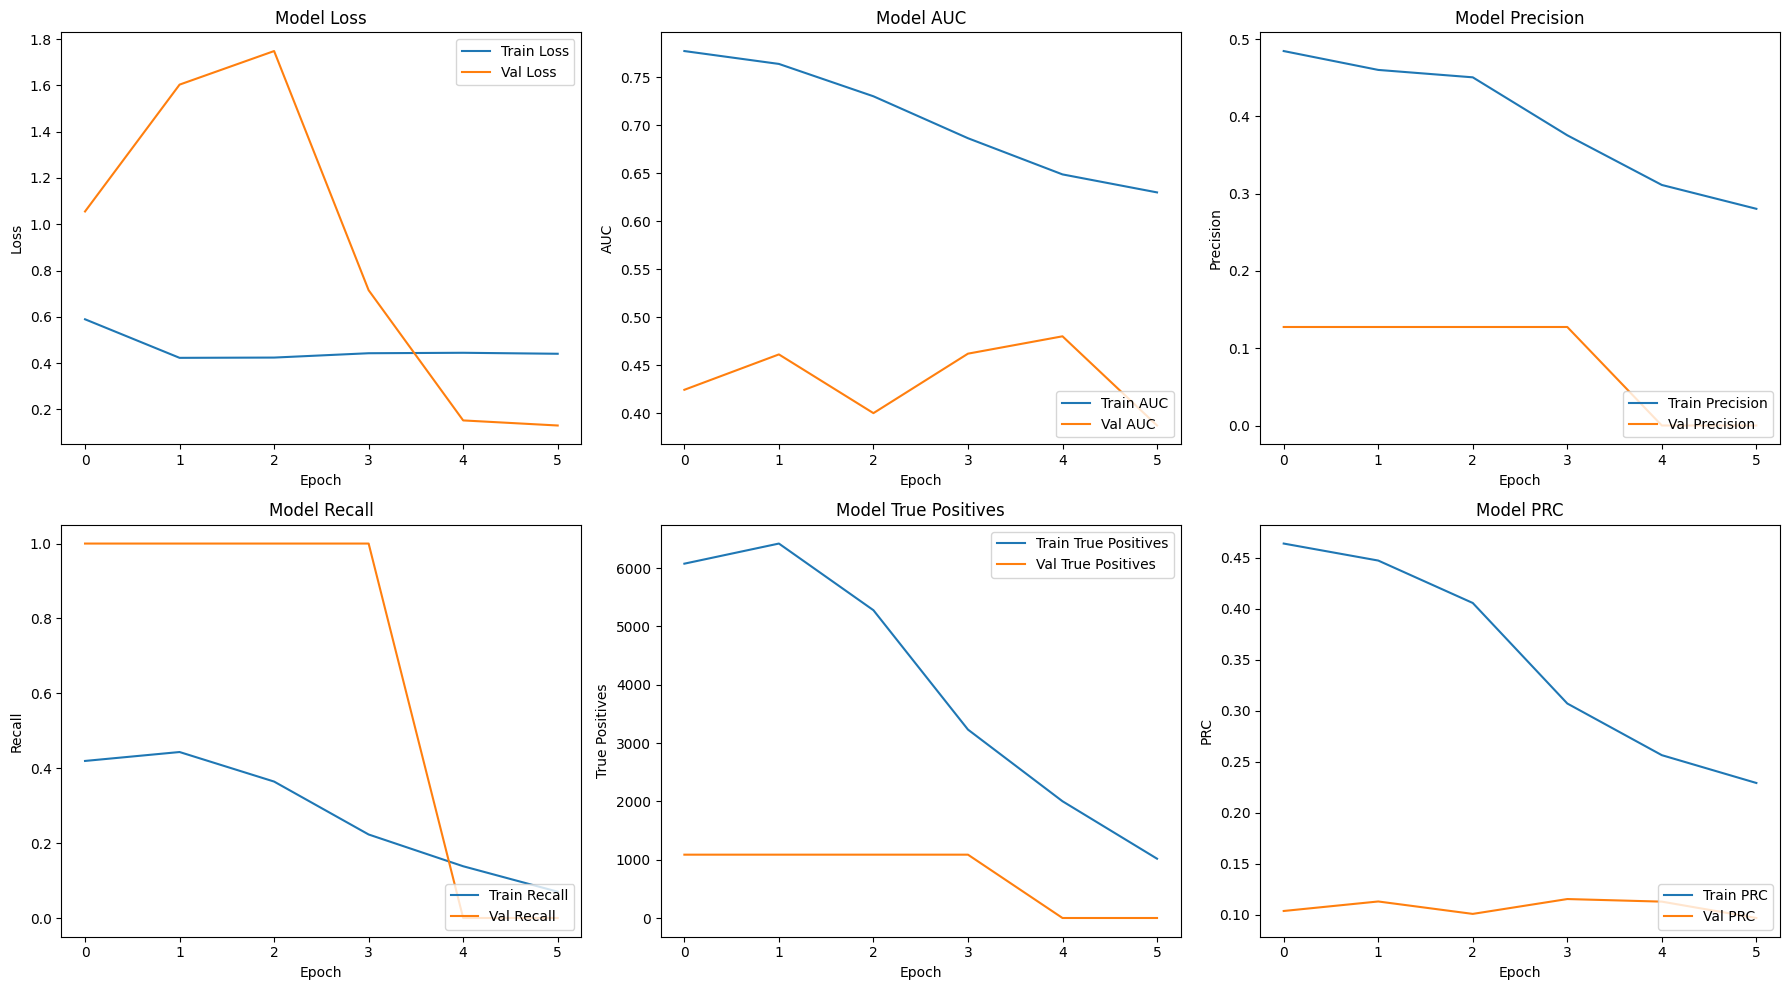

In [12]:
def plot_model_stats(history_dict):
    plt.figure(figsize=(18, 10))

    # Plotting Loss
    plt.subplot(2, 3, 1)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plotting AUC
    plt.subplot(2, 3, 2)
    plt.plot(history_dict['auc'], label='Train AUC')
    plt.plot(history_dict['val_auc'], label='Val AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(loc='lower right')

    # Plotting Precision
    plt.subplot(2, 3, 3)
    plt.plot(history_dict['p'], label='Train Precision')
    plt.plot(history_dict['val_p'], label='Val Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')

    # Plotting Recall
    plt.subplot(2, 3, 4)
    plt.plot(history_dict['r'], label='Train Recall')
    plt.plot(history_dict['val_r'], label='Val Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='lower right')

    # Plotting True Positives
    plt.subplot(2, 3, 5)
    plt.plot(history_dict['tp'], label='Train True Positives')
    plt.plot(history_dict['val_tp'], label='Val True Positives')
    plt.title('Model True Positives')
    plt.xlabel('Epoch')
    plt.ylabel('True Positives')
    plt.legend(loc='upper right')

    # Plotting PRC (Precision-Recall Curve)
    plt.subplot(2, 3, 6)
    plt.plot(history_dict['prc'], label='Train PRC')
    plt.plot(history_dict['val_prc'], label='Val PRC')
    plt.title('Model PRC')
    plt.xlabel('Epoch')
    plt.ylabel('PRC')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig(f'{IMAGES_DIR}/{MODEL_NAME}_stats.png')
    plt.show()

if history_dict is not None:
    plot_model_stats(history_dict)

# Explain and Interpret

2024-06-01 22:29:44.807986: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-01 22:29:44.860841: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-06-01 22:29:44.940154: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


14/14 [==============================] - 4s 96ms/step


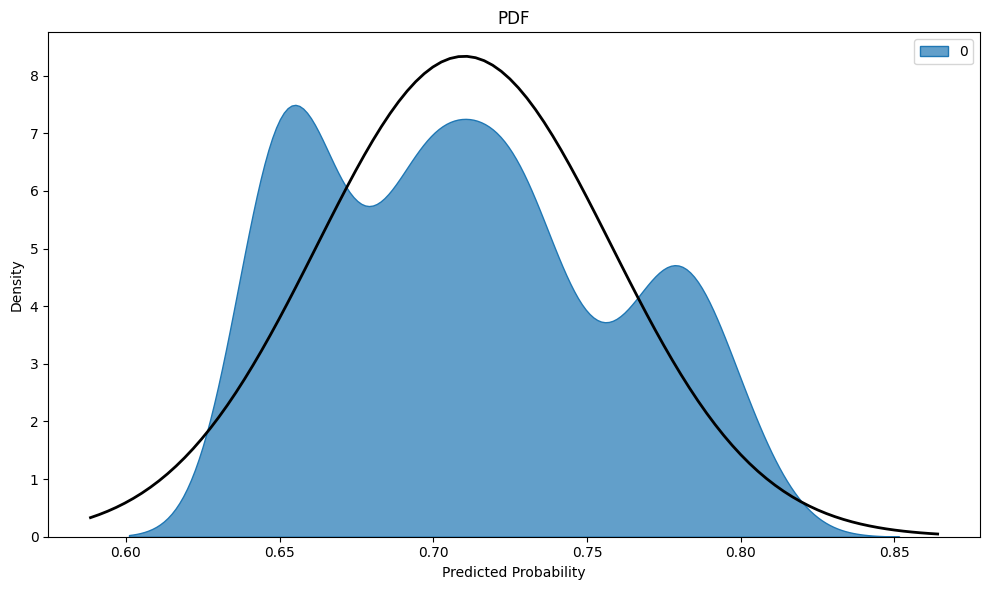

,0
Accuracy,0.091549
Precision,0.091549
Recall,1.000000
F1b Score,0.008457
ROC AUC,0.383091


In [13]:
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score

def print_metrics_and_distribution(model, data, labels):
    ypred_proba = model.predict(data)
    pred = (ypred_proba > 0.5).astype(int)

    metrics = {
        "Accuracy": accuracy_score(labels.flatten(), pred.flatten()),
        "Precision": precision_score(labels.flatten(), pred.flatten()),
        "Recall": recall_score(labels.flatten(), pred.flatten()),
        "F1b Score": fbeta_score(labels.flatten(), pred.flatten(), average="weighted", beta=0.1),
        "ROC AUC": roc_auc_score(labels.flatten(), ypred_proba.flatten(), average='weighted')
    }

    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

    plt.figure(figsize=(10, 6))
    sns.kdeplot(ypred_proba, color='blue', fill=True, alpha=0.7)

    mu, std = norm.fit(ypred_proba)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    plt.title('PDF')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.savefig(f'{IMAGES_DIR}/{MODEL_NAME}_pdf.png')
    plt.show()

    metrics_df.to_json(f"{MODEL_PATH}/stats.json")

    return metrics_df

test_data, test_labels = prepare_windows(val_agri_ts[0][FEATURES], val_agri_ts[0][META_LABEL], window_size=WINDOW)
metrics_df = print_metrics_and_distribution(model, test_data, test_labels)
metrics_df

14/14 [==============================] - 0s 24ms/step


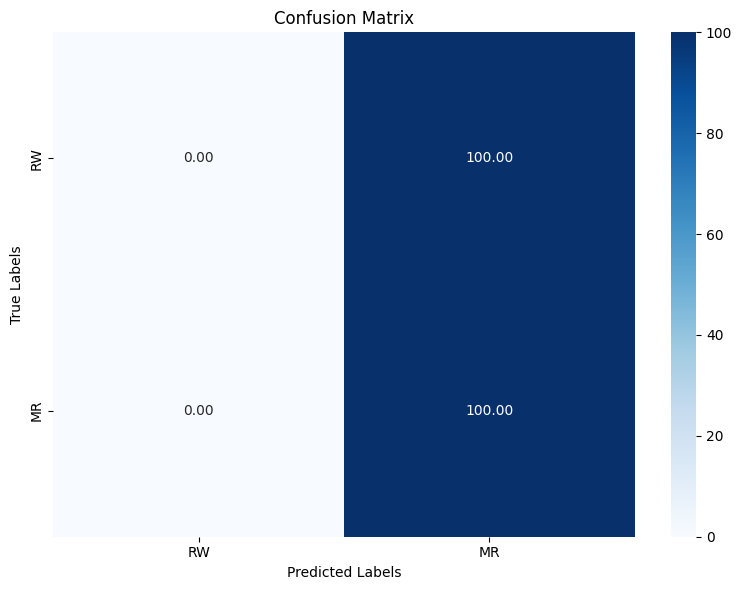

In [14]:
import seaborn as sns

from tensorflow.math import confusion_matrix

def plot_confusion_matrix(model, data, labels, label_names=['RW', 'MR']):
    ypred_proba = model.predict(data)
    pred = (ypred_proba > 0.5).astype(int)
    cm = confusion_matrix(labels.flatten(), pred)

    plt.figure(figsize=(8, 6))
    df_cm = pd.DataFrame((cm / np.sum(cm, axis=1)[:, None])*100, index=[i for i in label_names], columns=[i for i in label_names])
    cm_plot = sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.savefig(f'{IMAGES_DIR}/{MODEL_NAME}_cm.png')
    plt.show()

plot_confusion_matrix(model, test_data, test_labels)

## SHAP

In [15]:
import shap
shap.initjs()

RANDOMIZE_SIZE = 32
SAMPLE_SIZE = 25

if MODEL_NAME != "WAVENET":
    # Shap doesn't work with window encoded data.
    background_features, background_labels = prepare_windows(train_agri_ts[0][FEATURES], train_agri_ts[0][META_LABEL], window_size=WINDOW)
    background_features, background_labels =background_features[:SAMPLE_SIZE], background_labels[:SAMPLE_SIZE]
    test_features, test_labels = test_data[:SAMPLE_SIZE], test_labels[:SAMPLE_SIZE]

    shap.explainers._deep.deep_tf.op_handlers["LeakyRelu"] = shap.explainers._deep.deep_tf.op_handlers["Relu"]
    shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.op_handlers["Add"]
    shap.explainers._deep.deep_tf.op_handlers["BatchToSpaceND"] = shap.explainers._deep.deep_tf.op_handlers["Mean"]
    shap.explainers._deep.deep_tf.op_handlers["SpaceToBatchND"] = shap.explainers._deep.deep_tf.op_handlers["Mean"]
    # this is a hack: https://github.com/shap/shap/issues/1463

    e = shap.DeepExplainer(model, background_features)

    shap_values = e.shap_values(test_features)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    shap_values = np.squeeze(shap_values)

    print(f"SHAP values shape: {shap_values.shape}")
    print(f"Test features shape: {test_features.shape}")
    assert shap_values.shape == test_features.shape
    shap.summary_plot(shap_values, test_features)
    plt.savefig(f'{IMAGES_DIR}/{MODEL_NAME}_shap_sum.png')

In [16]:
if MODEL_NAME != "WAVENET":
    sample_index = 2
    e = shap.KernelExplainer(model, background_features)

    select = range(20)
    shap_features = test_features[select]
    train_features = background_features[select]
    print(shap_features.shape)
    shap_values = e.shap_values(shap_features, nsamples=SAMPLE_SIZE)
    print(f"SHAP values shape: {shap_values.shape}")

    if isinstance(shap_values, list):
        shap_values = shap_values[0: SAMPLE_SIZE]
    shap_values = np.squeeze(shap_values)
    y_pred = (shap_values.sum(1) + e.expected_value) > 0
    misclassified = y_pred != test_labels[select]
    print(f"Misclassified: {np.shape(misclassified)} out of {np.shape(y_pred)[0]}")

    print(f"Explainer expected value: {e.expected_value}")
    shap.decision_plot(e.expected_value, shap_values, train_features, feature_names=FEATURES, link='logit', highlight=misclassified[0])
    plt.savefig(f'{IMAGES_DIR}/{MODEL_NAME}_shap_dec.png')

In [17]:
if MODEL_NAME != "WAVENET":
    shap.decision_plot(
        e.expected_value,
        shap_values[misclassified],
        train_features[misclassified],
        link="logit",
        highlight=0,
        feature_names=FEATURES
    )
    plt.savefig(f'{IMAGES_DIR}/{MODEL_NAME}_shap_force.png')

    shap.force_plot(
        e.expected_value,
        shap_values[misclassified],
        train_features[misclassified],
        link="logit",
        feature_names=FEATURES
    )
    plt.savefig(f'{IMAGES_DIR}/{MODEL_NAME}_shap_force_misclassed.png')